<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка данных</a></span><ul class="toc-item"><li><span><a href="#Изменение-типа-данных" data-toc-modified-id="Изменение-типа-данных-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Изменение типа данных</a></span></li></ul></li><li><span><a href="#Исследование-задачи" data-toc-modified-id="Исследование-задачи-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Исследование задачи</a></span></li><li><span><a href="#Борьба-с-дисбалансом" data-toc-modified-id="Борьба-с-дисбалансом-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Борьба с дисбалансом</a></span></li><li><span><a href="#Тестирование-модели" data-toc-modified-id="Тестирование-модели-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование модели</a></span></li><li><span><a href="#Чек-лист-готовности-проекта" data-toc-modified-id="Чек-лист-готовности-проекта-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Чек-лист готовности проекта</a></span></li></ul></div>

# Отток клиентов

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Вам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком. 

Постройте модель с предельно большим значением *F1*-меры. Чтобы сдать проект успешно, нужно довести метрику до 0.59. Проверьте *F1*-меру на тестовой выборке самостоятельно.

Дополнительно измеряйте *AUC-ROC*, сравнивайте её значение с *F1*-мерой.

Источник данных: [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)

## Подготовка данных

Используемые библиотеки

In [230]:
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier 
from sklearn.model_selection import train_test_split, GridSearchCV,RandomizedSearchCV
from sklearn.metrics import mean_squared_error,accuracy_score, f1_score,r2_score,mean_absolute_error
from sklearn.preprocessing import OneHotEncoder,PolynomialFeatures,MinMaxScaler,StandardScaler
from sklearn.utils import shuffle
from sklearn.dummy import DummyClassifier
import matplotlib.pyplot as plt
import seaborn as sns 
import numpy as np
pd.options.display.float_format ='{:,.3f}'.format

Используемые функции

In [130]:
def df_info(df):
    all_data = df.reset_index(drop=True)    
    all_data_na = (all_data.isna().sum() / len(all_data))
    missing_data = pd.DataFrame({'тип': df.dtypes})
    if len(all_data_na[all_data_na!=0])>0:
        missing_data['пропуски']= all_data_na.map("{:.1%}".format)
        display(missing_data)
        print('Столбцов с NA:',len(all_data_na[all_data_na!=0]),'из',df.shape[1])
    else:
        display(missing_data)
        print('Пропусков нет.') 
    if df.duplicated().sum()>0:
        print('Дубликатов:',df.duplicated().sum())
    else:
        print('Дубликатов нет')
    print(f'Структура : {all_data.shape}')
    
def optimizing_df(df):
    for col in df.columns:
        if df[col].dtypes.kind == 'i' or df[col].dtypes.kind == 'u':
            if df[col].min() >= 0:
                df[col] = pd.to_numeric(df[col], downcast='unsigned')
            else:
                df[col] = pd.to_numeric(df[col], downcast='integer')
        elif df[col].dtypes.kind == 'f' or df[col].dtypes.kind == 'c':
            df[col] = pd.to_numeric(df[col], downcast='float')
        elif df[col].dtypes.kind == 'O':
            num_unique_values = len(df[col].unique())
            num_total_values = len(df[col])
            if num_unique_values / num_total_values < 0.5:
                df[col] = df[col].astype('category')
    return df

def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=12345)
    
    return features_upsampled, target_upsampled

def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=12345)] + [features_ones])
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=12345)] + [target_ones])
    
    features_downsampled, target_downsampled = shuffle(
        features_downsampled, target_downsampled, random_state=12345)
    
    return features_downsampled, target_downsampled

Загрузка датасета

In [3]:
df = pd.read_csv('Churn.csv')
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.000,0.000,1,1,1,"101,348.880",1
1,2,15647311,Hill,608,Spain,Female,41,1.000,"83,807.860",1,0,1,"112,542.580",0
2,3,15619304,Onio,502,France,Female,42,8.000,"159,660.800",3,1,0,"113,931.570",1
3,4,15701354,Boni,699,France,Female,39,1.000,0.000,2,0,0,"93,826.630",0
4,5,15737888,Mitchell,850,Spain,Female,43,2.000,"125,510.820",1,1,1,"79,084.100",0


Приведем названия параметров к нижнему регистру

In [4]:
df.columns = df.columns.str.lower()

Проверим значения на наличие выбросов

In [5]:
df.geography.unique()

array(['France', 'Spain', 'Germany'], dtype=object)

In [6]:
df.gender.unique()

array(['Female', 'Male'], dtype=object)

In [7]:
df.age.unique()

array([42, 41, 39, 43, 44, 50, 29, 27, 31, 24, 34, 25, 35, 45, 58, 32, 38,
       46, 36, 33, 40, 51, 61, 49, 37, 19, 66, 56, 26, 21, 55, 75, 22, 30,
       28, 65, 48, 52, 57, 73, 47, 54, 72, 20, 67, 79, 62, 53, 80, 59, 68,
       23, 60, 70, 63, 64, 18, 82, 69, 74, 71, 76, 77, 88, 85, 84, 78, 81,
       92, 83], dtype=int64)

In [8]:
df.numofproducts.unique()

array([1, 3, 2, 4], dtype=int64)

In [9]:
df.hascrcard.unique()

array([1, 0], dtype=int64)

In [10]:
df.isactivemember.unique()

array([1, 0], dtype=int64)

In [11]:
df.exited.unique()

array([1, 0], dtype=int64)

In [12]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
rownumber,"10,000.000","5,000.500","2,886.896",1.000,"2,500.750","5,000.500","7,500.250","10,000.000"
customerid,"10,000.000","15,690,940.569","71,936.186","15,565,701.000","15,628,528.250","15,690,738.000","15,753,233.750","15,815,690.000"
creditscore,"10,000.000",650.529,96.653,350.000,584.000,652.000,718.000,850.000
age,"10,000.000",38.922,10.488,18.000,32.000,37.000,44.000,92.000
tenure,"9,091.000",4.998,2.895,0.000,2.000,5.000,7.000,10.000
balance,"10,000.000","76,485.889","62,397.405",0.000,0.000,"97,198.540","127,644.240","250,898.090"
numofproducts,"10,000.000",1.530,0.582,1.000,1.000,1.000,2.000,4.000
hascrcard,"10,000.000",0.706,0.456,0.000,0.000,1.000,1.000,1.000
isactivemember,"10,000.000",0.515,0.500,0.000,0.000,1.000,1.000,1.000
estimatedsalary,"10,000.000","100,090.240","57,510.493",11.580,"51,002.110","100,193.915","149,388.247","199,992.480"


Выбросы отсутствуют.

Проверим значения на наличие пропусков и дубликатов.

In [13]:
df_info(df)

,тип,пропуски
rownumber,int64,0.0%
customerid,int64,0.0%
surname,object,0.0%
creditscore,int64,0.0%
geography,object,0.0%
gender,object,0.0%
age,int64,0.0%
tenure,float64,9.1%
balance,float64,0.0%
numofproducts,int64,0.0%


Столбцов с NA: 1 из 14
Дубликатов нет
Структура : (10000, 14)


Имеются пропуски по признаку 'tenure'. 9% довольно существенно для удаления. Попробуем найти критерии для восстановления или замены пропусков.

Посмотрим корреляцию по tenure, да и всех признаков в целом.

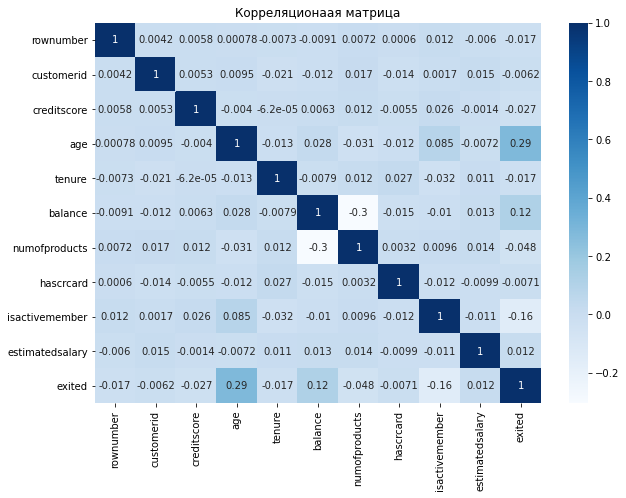

In [14]:
plt.figure(figsize = (10,7))
sns.heatmap(df.corr(), cmap = 'Blues', annot = True)
plt.title('Корреляционаая матрица')
plt.show()

Какая либо значимая корреляция между признаками отсутствует.

Посмотрим строки с пропущенными значениями

In [15]:
df.loc[df.tenure.isna()]

,rownumber,customerid,surname,creditscore,geography,gender,age,tenure,balance,numofproducts,hascrcard,isactivemember,estimatedsalary,exited
30,31,15589475,Azikiwe,591,Spain,Female,39,NaN,0.000,3,1,0,"140,469.380",1
48,49,15766205,Yin,550,Germany,Male,38,NaN,"103,391.380",1,0,1,"90,878.130",0
51,52,15768193,Trevisani,585,Germany,Male,36,NaN,"146,050.970",2,0,0,"86,424.570",0
53,54,15702298,Parkhill,655,Germany,Male,41,NaN,"125,561.970",1,0,0,"164,040.940",1
60,61,15651280,Hunter,742,Germany,Male,35,NaN,"136,857.000",1,0,0,"84,509.570",0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9944,9945,15703923,Cameron,744,Germany,Male,41,NaN,"190,409.340",2,1,1,"138,361.480",0
9956,9957,15707861,Nucci,520,France,Female,46,NaN,"85,216.610",1,1,0,"117,369.520",1
9964,9965,15642785,Douglas,479,France,Male,34,NaN,"117,593.480",2,0,0,"113,308.290",0
9985,9986,15586914,Nepean,659,France,Male,36,NaN,"123,841.490",2,1,0,"96,833.000",0


Попробуем понять к чему относятся пропущенные значения по времени использования услуг. 

In [16]:
df.groupby('tenure',dropna=False).agg('median')

,rownumber,customerid,creditscore,age,balance,numofproducts,hascrcard,isactivemember,estimatedsalary,exited
tenure,,,,,,,,,,
0.000,"5,107.500","15,696,410.000",653.000,38.000,"101,050.445",1.000,1.000,1.000,"102,160.510",0.000
1.000,"5,167.000","15,692,461.000",652.000,38.000,"97,842.705",1.000,1.000,1.000,"101,970.470",0.000
2.000,"4,972.500","15,696,847.000",655.000,38.000,"97,364.045",2.000,1.000,1.000,"97,613.545",0.000
3.000,"4,845.500","15,697,350.500",652.000,37.000,"99,739.770",1.000,1.000,1.000,"94,368.490",0.000
4.000,"5,089.000","15,690,164.000",651.000,37.000,"93,059.340",1.000,1.000,1.000,"101,371.050",0.000
5.000,"4,897.000","15,680,683.000",654.000,38.000,"94,754.000",2.000,1.000,1.000,"100,941.570",0.000
6.000,"5,079.000","15,692,291.000",648.000,37.000,"96,166.880",1.000,1.000,1.000,"98,090.910",0.000
7.000,"4,905.000","15,690,939.000",650.000,37.000,"97,459.060",1.000,1.000,1.000,"104,379.360",0.000
8.000,"4,857.000","15,684,921.000",651.000,37.000,"98,649.550",1.000,1.000,1.000,"99,654.130",0.000


In [17]:
sub=df.groupby('tenure',dropna=False).agg('median')
sub.loc[(sub.index==0.0) | (sub.index==10.0) | (sub.index.isna())]

,rownumber,customerid,creditscore,age,balance,numofproducts,hascrcard,isactivemember,estimatedsalary,exited
tenure,,,,,,,,,,
0.000,"5,107.500","15,696,410.000",653.000,38.000,"101,050.445",1.000,1.000,1.000,"102,160.510",0.000
10.000,"5,158.500","15,692,923.500",651.500,38.000,"92,327.835",2.000,1.000,1.000,"101,505.860",0.000
NaN,"4,887.000","15,686,870.000",647.000,37.000,"96,674.550",1.000,1.000,1.000,"99,444.020",0.000


Принадлежность к определенной группе прослеживается слабо. Но мы видим, что преобладающее количество открытых продуктов равно 1. Поэтому будем считать, что пропуски в параметре - это клиенты, которые пользовались услугами меньше года. Заменим все пропуски на 0.

In [18]:
df['tenure']=df['tenure'].fillna(0)

Изменим типы данных для уменьшения занимаемой памяти и увеличения скорости вычислений.

In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   rownumber        10000 non-null  int64  
 1   customerid       10000 non-null  int64  
 2   surname          10000 non-null  object 
 3   creditscore      10000 non-null  int64  
 4   geography        10000 non-null  object 
 5   gender           10000 non-null  object 
 6   age              10000 non-null  int64  
 7   tenure           10000 non-null  float64
 8   balance          10000 non-null  float64
 9   numofproducts    10000 non-null  int64  
 10  hascrcard        10000 non-null  int64  
 11  isactivemember   10000 non-null  int64  
 12  estimatedsalary  10000 non-null  float64
 13  exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


In [21]:
df=optimizing_df(df)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   rownumber        10000 non-null  uint16  
 1   customerid       10000 non-null  uint32  
 2   surname          10000 non-null  category
 3   creditscore      10000 non-null  uint16  
 4   geography        10000 non-null  category
 5   gender           10000 non-null  category
 6   age              10000 non-null  uint8   
 7   tenure           10000 non-null  float32 
 8   balance          10000 non-null  float32 
 9   numofproducts    10000 non-null  uint8   
 10  hascrcard        10000 non-null  uint8   
 11  isactivemember   10000 non-null  uint8   
 12  estimatedsalary  10000 non-null  float32 
 13  exited           10000 non-null  uint8   
dtypes: category(3), float32(3), uint16(2), uint32(1), uint8(5)
memory usage: 371.0 KB


Используем OrdinalEncoder для преобразования категорийных признаков к числу

In [22]:
df = df.join(pd.get_dummies(df.gender, prefix='g'))
df = df.join(pd.get_dummies(df.geography, prefix='geo'))
df

,rownumber,customerid,surname,creditscore,geography,gender,age,tenure,balance,numofproducts,hascrcard,isactivemember,estimatedsalary,exited,g_Female,g_Male,geo_France,geo_Germany,geo_Spain
0,1,15634602,Hargrave,619,France,Female,42,2.000,0.000,1,1,1,"101,348.883",1,1,0,1,0,0
1,2,15647311,Hill,608,Spain,Female,41,1.000,"83,807.859",1,0,1,"112,542.578",0,1,0,0,0,1
2,3,15619304,Onio,502,France,Female,42,8.000,"159,660.797",3,1,0,"113,931.570",1,1,0,1,0,0
3,4,15701354,Boni,699,France,Female,39,1.000,0.000,2,0,0,"93,826.633",0,1,0,1,0,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.000,"125,510.820",1,1,1,"79,084.102",0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9996,15606229,Obijiaku,771,France,Male,39,5.000,0.000,2,1,0,"96,270.641",0,0,1,1,0,0
9996,9997,15569892,Johnstone,516,France,Male,35,10.000,"57,369.609",1,1,1,"101,699.773",0,0,1,1,0,0
9997,9998,15584532,Liu,709,France,Female,36,7.000,0.000,1,0,1,"42,085.578",1,1,0,1,0,0
9998,9999,15682355,Sabbatini,772,Germany,Male,42,3.000,"75,075.312",2,1,0,"92,888.523",1,0,1,0,1,0


Проведем разбиение данных на обучающую, валидационную и тестовую.

In [25]:
features = df.drop(['rownumber', 'customerid', 'surname', 'geography','gender','exited'],axis=1)
target = df['exited']

In [97]:
features_train, features_valid, target_train, target_valid = train_test_split(features, target, test_size=.4,\
                                                                              random_state=12345, stratify=target)
features_valid, features_test, target_valid, target_test = train_test_split(features_valid, target_valid, test_size=0.5,\
                                                                              random_state=12345, stratify=target_valid)
print(f'Размер обучающей выборки: {features_train.shape}')
print(f'Размер валидационной выборки: {features_valid.shape}')
print(f'Размер тестовой выборки: {features_test.shape}')

Размер обучающей выборки: (6000, 13)
Размер валидационной выборки: (2000, 13)
Размер тестовой выборки: (2000, 13)


Используем StadardScaler чтобы привести данные к единообразному удобоваримому виду, сделаем масштабирование. 

In [51]:
scaler = StandardScaler()  
scaler.fit(features_train)
features_train = scaler.transform(features_train)
features_valid = scaler.transform(features_valid) 
features_test = scaler.transform(features_test)

## Исследование задачи

Исследуем баланс классов

In [23]:
df['exited'].value_counts(normalize=True)

0   0.796
1   0.204
Name: exited, dtype: float64

Факт ухода клиента был зафиксирован в 20% случаев. Баланс классов составляет 1:4.

Рассмотрим четыре модели для обучения и сравнения предсказаний:
- Логистическая регрессия
- Случайный лес
- Древо решений
- XGB

In [110]:
model = LogisticRegression(random_state=12345)
model.fit(features_train,target_train) 
probabilities_one_valid = model.predict_proba(features_valid)[:, 1]
print("f1 score:", f1_score(target_valid,model.predict(features_valid)))
print("ROC-AUC:", roc_auc_score(target_valid, probabilities_one_valid))

f1 score: 0.06181015452538632
ROC-AUC: 0.699597866784905


In [111]:
model = DecisionTreeClassifier(random_state=12345)
model.fit(features_train,target_train) 
probabilities_one_valid = model.predict_proba(features_valid)[:, 1]
print("f1 score:", f1_score(target_valid,model.predict(features_valid)))
print("ROC-AUC:", roc_auc_score(target_valid, probabilities_one_valid))

f1 score: 0.5126436781609195
ROC-AUC: 0.6982214996551384


In [112]:
model = RandomForestClassifier(random_state=12345)
model.fit(features_train,target_train) 
probabilities_one_valid = model.predict_proba(features_valid)[:, 1]
print("f1 score:", f1_score(target_valid,model.predict(features_valid)))
print("ROC-AUC:", roc_auc_score(target_valid, probabilities_one_valid))

f1 score: 0.591044776119403
ROC-AUC: 0.8582426532170658


In [113]:
model = xgb.XGBClassifier(random_state=12345,eval_metric='logloss',use_label_encoder=False)
model.fit(features_train,target_train)
probabilities_one_valid = model.predict_proba(features_valid)[:, 1]
print("f1 score:", f1_score(target_valid,model.predict(features_valid)))
print("ROC-AUC:", roc_auc_score(target_valid, probabilities_one_valid))

f1 score: 0.6145251396648044
ROC-AUC: 0.8581002438663907


В целом, данные не сбалансированы по целевому признаку и имеют распределение 1 к 4. Лучшие показатели метрики у XGB, f1 score составил 0.61, ROC-AUC - 0.85, худшие у логистической регрессии. Модели были построены без учета дисбаланса классов, а это значит, что можно попробовать улучшить результаты.

## Борьба с дисбалансом

Исправление дисбаланса может быть проведено 4 способами:
- взвешивание классов
- увеличение выборки
- уменьшение выборки
- изменение порога классификации

### Взвешивание классов

Построим модели с гиперпараметрами определяющим балансировку классов, выведем f1-метрику и AUC-ROC

In [114]:
model = LogisticRegression(random_state=12345,class_weight='balanced')
model.fit(features_train,target_train) 
probabilities_one_valid = model.predict_proba(features_valid)[:, 1]
print("f1 score:", f1_score(target_valid,model.predict(features_valid)))
print("ROC-AUC:", roc_auc_score(target_valid, probabilities_one_valid))

f1 score: 0.4678076609616952
ROC-AUC: 0.738109973889053


In [116]:
model = DecisionTreeClassifier(random_state=12345,class_weight='balanced')
model.fit(features_train,target_train) 
probabilities_one_valid = model.predict_proba(features_valid)[:, 1]
print("f1 score:", f1_score(target_valid,model.predict(features_valid)))
print("ROC-AUC:", roc_auc_score(target_valid, probabilities_one_valid))

f1 score: 0.5018181818181818
ROC-AUC: 0.6877216967188885


In [117]:
model = RandomForestClassifier(random_state=12345,class_weight='balanced')
model.fit(features_train,target_train) 
probabilities_one_valid = model.predict_proba(features_valid)[:, 1]
print("f1 score:", f1_score(target_valid,model.predict(features_valid)))
print("ROC-AUC:", roc_auc_score(target_valid, probabilities_one_valid))

f1 score: 0.5761689291101055
ROC-AUC: 0.8604303687555425


In [115]:
model = xgb.XGBClassifier(random_state=12345,eval_metric='logloss',use_label_encoder=False,class_weight='balanced')
model.fit(features_train,target_train) 
probabilities_one_valid = model.predict_proba(features_valid)[:, 1]
print("f1 score:", f1_score(target_valid,model.predict(features_valid)))
print("ROC-AUC:", roc_auc_score(target_valid, probabilities_one_valid))

[19:00:32] WARNING: D:\bld\xgboost-split_1631904903843\work\src\learner.cc:573: 
Parameters: { "class_weight" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


f1 score: 0.6145251396648044
ROC-AUC: 0.8581002438663907


Использование балансировки классов не привело к значительному улучшению результатов. Только у логистической регресси результаты были улучшены, у случайного леса и дерева решений они почти не изменились, а на XGB это вообще никак не повлияло, т.к уже присутствует встроенная балансировка. Отсюда следует вывод, что балансировка может улучшиить показатели качества более простых моделей, для моделей представляющих более сложное решение, она менее эффективна.

### Увеличение выборки

Используем метод увеличения выборки. Для этого проведем разбиение и сделаем новую обучающую выборку. 

In [235]:
features_train, features_valid, target_train, target_valid = train_test_split(features, target, test_size=.4,\
                                                                              random_state=12345, stratify=target)
features_valid, features_test, target_valid, target_test = train_test_split(features_valid, target_valid, test_size=0.5,\
                                                                              random_state=12345, stratify=target_valid)
features_upsampled, target_upsampled = upsample(features_train, target_train, 10)

In [132]:
model = LogisticRegression(random_state=12345,class_weight='balanced')
model.fit(features_upsampled, target_upsampled) 
probabilities_one_valid = model.predict_proba(features_valid)[:, 1]
print("f1 score:", f1_score(target_valid,model.predict(features_valid)))
print("ROC-AUC:", roc_auc_score(target_valid, probabilities_one_valid))

f1 score: 0.4678076609616952
ROC-AUC: 0.738109973889053


In [119]:
model = DecisionTreeClassifier(random_state=12345)
model.fit(features_upsampled, target_upsampled) 
probabilities_one_valid = model.predict_proba(features_valid)[:, 1]
print("f1 score:", f1_score(target_valid,model.predict(features_valid)))
print("ROC-AUC:", roc_auc_score(target_valid, probabilities_one_valid))

f1 score: 0.5069356872635562
ROC-AUC: 0.6885345846881467


In [120]:
model = RandomForestClassifier(random_state=12345)
model.fit(features_upsampled, target_upsampled) 
probabilities_one_valid = model.predict_proba(features_valid)[:, 1]
print("f1 score:", f1_score(target_valid,model.predict(features_valid)))
print("ROC-AUC:", roc_auc_score(target_valid, probabilities_one_valid))

f1 score: 0.6133682830930538
ROC-AUC: 0.8589947285446842


In [121]:
model = xgb.XGBClassifier(random_state=12345,eval_metric='logloss',use_label_encoder=False)
model.fit(features_upsampled, target_upsampled)  
probabilities_one_valid = model.predict_proba(features_valid)[:, 1]
print("f1 score:", f1_score(target_valid,model.predict(features_valid)))
print("ROC-AUC:", roc_auc_score(target_valid, probabilities_one_valid))

f1 score: 0.5977933801404213
ROC-AUC: 0.8564529140802049


На дерево решений, xgb и логистическую увеличение выборки повлияло не значительно, а вот метрика случайного леса повысилась.

### Уменьшение выборки

Проведем уменьшение выборки и посмотрим влияние на модели по изменениям метрики.

In [124]:
features_downsampled, target_downsampled = downsample(features_train, target_train, 0.2)

In [125]:
model = LogisticRegression(random_state=12345,class_weight='balanced')
model.fit(features_downsampled, target_downsampled) 
probabilities_one_valid = model.predict_proba(features_valid)[:, 1]
print("f1 score:", f1_score(target_valid,model.predict(features_valid)))
print("ROC-AUC:", roc_auc_score(target_valid, probabilities_one_valid))

f1 score: 0.37046802900461434
ROC-AUC: 0.5971909178244162


In [127]:
model = DecisionTreeClassifier(random_state=12345)
model.fit(features_upsampled, target_upsampled) 
probabilities_one_valid = model.predict_proba(features_valid)[:, 1]
print("f1 score:", f1_score(target_valid,model.predict(features_valid)))
print("ROC-AUC:", roc_auc_score(target_valid, probabilities_one_valid))

f1 score: 0.5069356872635562
ROC-AUC: 0.6885345846881467


In [128]:
model = RandomForestClassifier(random_state=12345)
model.fit(features_upsampled, target_upsampled) 
probabilities_one_valid = model.predict_proba(features_valid)[:, 1]
print("f1 score:", f1_score(target_valid,model.predict(features_valid)))
print("ROC-AUC:", roc_auc_score(target_valid, probabilities_one_valid))

f1 score: 0.6133682830930538
ROC-AUC: 0.8589947285446842


In [129]:
model = xgb.XGBClassifier(random_state=12345,eval_metric='logloss',use_label_encoder=False)
model.fit(features_upsampled, target_upsampled)  
probabilities_one_valid = model.predict_proba(features_valid)[:, 1]
print("f1 score:", f1_score(target_valid,model.predict(features_valid)))
print("ROC-AUC:", roc_auc_score(target_valid, probabilities_one_valid))

f1 score: 0.5977933801404213
ROC-AUC: 0.8564529140802049


Проведенные изменения также повлияли не значительно. В лидерах опять случайный лес, а влияние на метрики логистической регрессии дало обратный эффект.

В целом случайный лес и xgb показывают одинаково высокие параметры. Выберем случайный лес и попробуем оптимизировать гиперпараметры.

In [241]:
features_upsampled, target_upsampled = upsample(features_train, target_train, 10)
n_estimators = [int(x) for x in np.linspace(start = 50, stop = 300, num = 21)]
max_features = ['log2', 'sqrt']
max_depth = [int(x) for x in np.linspace(start = 2, stop = 25, num = 20)]
min_samples_split = [int(x) for x in np.linspace(start = 2, stop = 30, num = 19)]
min_samples_leaf = [int(x) for x in np.linspace(start = 2, stop = 30, num = 19)]
class_weight = ['balanced']
mod = RandomForestClassifier(random_state=12345)
param_dist = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'class_weight': class_weight}
rs = RandomizedSearchCV(mod, 
                        param_dist, 
                        n_iter = 300, 
                        cv = 5, 
                        verbose = 1, 
                        n_jobs=-1, 
                        random_state=12345)
rs.fit(features_upsampled, target_upsampled)
rs.best_params_

Fitting 5 folds for each of 300 candidates, totalling 1500 fits


{'n_estimators': 212,
 'min_samples_split': 5,
 'min_samples_leaf': 2,
 'max_features': 'log2',
 'max_depth': 17,
 'class_weight': 'balanced'}

In [242]:
rs_df = pd.DataFrame(rs.cv_results_).sort_values('rank_test_score').reset_index(drop=True)
rs_df = rs_df.drop([
            'mean_fit_time', 
            'std_fit_time', 
            'mean_score_time',
            'std_score_time', 
            'params', 
            'split0_test_score', 
            'split1_test_score', 
            'split2_test_score', 
            'std_test_score'],
            axis=1)
rs_df.head(2)

,param_n_estimators,param_min_samples_split,param_min_samples_leaf,param_max_features,param_max_depth,param_class_weight,split3_test_score,split4_test_score,mean_test_score,rank_test_score
0,212,5,2,log2,17,balanced,0.966,0.960,0.966,1
1,175,2,2,sqrt,18,balanced,0.964,0.961,0.966,2


In [243]:
rs_df.mean_test_score.describe()

count   300.000
mean      0.838
std       0.053
min       0.742
25%       0.811
50%       0.834
75%       0.867
max       0.966
Name: mean_test_score, dtype: float64

Посмотрим на параметры модели влияющие на качество

Изучив параметры выше, а также параметров выданных поиском можно сделать вывод, что одним из лучших параметров для модели случайный лес будет:

    'n_estimators': 125,175,212
    'min_samples_split': 3,5
    'min_samples_leaf': 2,4
    'max_features': 'sqrt','log2
    'max_depth': 17

In [248]:
model = RandomForestClassifier(random_state=12345, n_estimators=212,min_samples_split=5,\
                    min_samples_leaf=2, max_features='log2', max_depth=17,class_weight='balanced')
model.fit(features_upsampled, target_upsampled) 
probabilities_one_valid = model.predict_proba(features_valid)[:, 1]
print("f1 score:", f1_score(target_valid,model.predict(features_valid)))
print("ROC-AUC:", roc_auc_score(target_valid, probabilities_one_valid))

f1 score: 0.6347305389221557
ROC-AUC: 0.8632223618090453


В результате исправления дисбаланса классов мы определили, что наши данные лучше всего классифицируются моделью RandomForestClassifier с балансировкой классов на данных, обработанных с помощью upsampling и гиперпараметрами найденными RandomizedSearchCV. Итоговое начение f1-score составляет 0.634, ROC-AUC - 0.863.

## Тестирование модели

Объединим обучающую и валидационную выборку и обучим модель на объединённой выборке.

In [249]:
features_train = features_train.append(features_valid)
target_train = target_train.append(target_valid)
print('Размер обьединенной выборки:', features_train.shape)

Размер обьединенной выборки: (8000, 13)


In [250]:
features_upsampled, target_upsampled = upsample(features_train, target_train, 10)

In [251]:
model = RandomForestClassifier(random_state=12345, n_estimators=175,min_samples_split=2,\
                    min_samples_leaf=2, max_features='sqrt', max_depth=22,class_weight='balanced')
model.fit(features_upsampled, target_upsampled) 
probabilities_one_test = model.predict_proba(features_test)[:, 1]
print("f1 score:", f1_score(target_test,model.predict(features_test)))
print("ROC-AUC:", roc_auc_score(target_test, probabilities_one_test))

f1 score: 0.5997521685254027
ROC-AUC: 0.8501814603509519


Тестовое значение f1-score составляет 0.60, ROC-AUC - 0.85, что немного меньше, чем на валидации. Это говорит о том, что присутствует переобучение модели в результате поиска идеальных гиперпараметров. 

Проверим модель на адекватность

In [231]:
model = DummyClassifier(strategy = 'most_frequent', random_state = 12345) 
model.fit(features_upsampled, target_upsampled)
print("f1 score:", f1_score(target_test,model.predict(features_test)))
print("ROC-AUC:", roc_auc_score(target_test, probabilities_one_test))

f1 score: 0.3381803074366431
ROC-AUC: 0.8523330726720558


Метрика f1 score DummyClassifier на тестовой выборке равна 0.34 ,а полученная нами модель имеет значение 0.6. Таким образом, мы можем считать модель адекватной для использования.

**Вывод:**

    1. Проведен Exploration data analysis:
        - заменены пропуски
        - форматирование параметров
        - оптимизированы типы
        - анализ корреляционных признаков   
    2. Применена техника прямого кодирования One-Hot Encoding
    3. Маштабированы количественные признаки с помощью метода стандартизаци данных.
    4. Исследован баланс классов
    5. В ходе исследования мы обучили и проверили влияние методов исправления дисбаланса на точность четырех моделей:
        - Логистическая регрессия
        - Случайный лес
        - Древо решений
        - XGB
    6. Путем тестирования модели выявилено незначительное переобучение 
    7. Проведена проверка модели на адекватность, сравнив результаты с результатами случайной модели.
    8. Для решения задачи классификации предлагается использовать модель RandomForestClassifier с балансировкой классов на данных, обработанных с помощью upsampling и следующими гиперпараметрами модели: 
        'n_estimators': 125,175,212
        'min_samples_split': 3,5
        'min_samples_leaf': 2,4
        'max_features': 'sqrt','log2
        'max_depth': 17

f1-score итоговой модели на тестовой выборке составляет: **0.6**, ROC-AUC - **0.85**

## Чек-лист готовности проекта

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Выполнен шаг 1: данные подготовлены
- [x]  Выполнен шаг 2: задача исследована
    - [x]  Исследован баланс классов
    - [x]  Изучены модели без учёта дисбаланса
    - [x]  Написаны выводы по результатам исследования
- [x]  Выполнен шаг 3: учтён дисбаланс
    - [x]  Применено несколько способов борьбы с дисбалансом
    - [x]  Написаны выводы по результатам исследования
- [x]  Выполнен шаг 4: проведено тестирование
- [x]  Удалось достичь *F1*-меры не менее 0.59
- [x]  Исследована метрика *AUC-ROC*